# Fashion Mnist Dataset - Classification

### Notebook Plan
In this project, we will compare between 3 classification models in terms of accuracy score of training set and test set as well as the training time and number of parameters. These indicators will be measured by training all models for 5 epochs as unified basis of comparison.

* Since the image data are pixels between (0,255) for color value, minimal preprocessing is needed: MinMaxScaler will be used to normalize both the training and the test data. For the target variable, one-hot encoding.
* Following the preprocessing, 3 models will be investigated:
    1. Dense neural network model (hidden unit of size 300)
    2. Dense neural network model with an Autoencoder used as a feature engineering step
    3. Convolutional neural network.


### Dataset Overview
this dataset contains images for 10 types of wear. These images are grey-colored and of size 28x28 pixels.

In [16]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras.backend as K
import tensorflow.keras as kr

%matplotlib inline

In [10]:
df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

The below image illustrate the first 5 rows of the data. The first column is the target variable named “label”

In [12]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


No skewness in the target varaible as we can see below

In [11]:
df_train.label.value_counts()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

In [13]:
# We need to view a sample taken from all the categories
image_samples = df_train.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

In [14]:
# Merging all the sampled images into one picture
img = np.zeros((2*28, 5*28))
for i in range(2):
    for j in range(5):
        img[i*28: (i + 1) * 28, j*28: (j + 1) * 28] = image_samples.iloc[5*i + j, 1:].values.reshape(28,28)

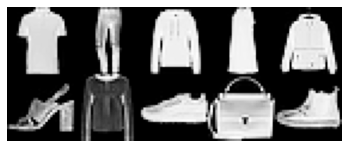

In [9]:
plt.imshow(img, cmap='Greys_r')
_ = plt.axis('off')

### Prerocessing

In [17]:
# Loading X, y datasets and preprocessing
X_train = df_train.iloc[:,1:]
y_train = df_train['label']

X_test = df_test.iloc[:,1:]
y_test = df_test['label']

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [19]:
# Encode target variable into one-hot encoding
y_train_ohe = kr.utils.to_categorical(y_train)
y_test_ohe = kr.utils.to_categorical(y_test)

---

## Section One: 1 HU Dense Network (Layer Size 300)

In [18]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

In [21]:
Dense_Model = Sequential(name="Dense_NN_Model")

In [22]:
Dense_Model.add(Input((784,), name='model1_input'))
Dense_Model.add(Dense(300, activation='relu', name='model1_hidden_unit'))
Dense_Model.add(Dense(10, activation='softmax', name='model1_output'))

In [23]:
rmsprop = kr.optimizers.RMSprop(learning_rate=0.0005)
Dense_Model.compile(rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
Dense_Model.summary()

Model: "Dense_NN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model1_hidden_unit (Dense)  (None, 300)               235500    
                                                                 
 model1_output (Dense)       (None, 10)                3010      
                                                                 
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


In [25]:
Dense_history = Dense_Model.fit(X_train, y_train_ohe, epochs=5, batch_size=32, validation_data=(X_test, y_test_ohe))

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5065 - accuracy: 0.8215 - val_loss: 0.4714 - val_accuracy: 0.8274
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3779 - accuracy: 0.8644 - val_loss: 0.3627 - val_accuracy: 0.8714
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3420 - accuracy: 0.8773 - val_loss: 0.3407 - val_accuracy: 0.8764
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3216 - accuracy: 0.8849 - val_loss: 0.3577 - val_accuracy: 0.8749
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3063 - accuracy: 0.8903 - val_loss: 0.3276 - val_accuracy: 0.8865


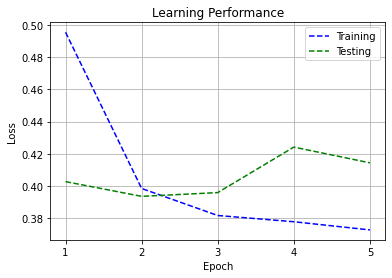

In [73]:
hist = Dense_history.history
plt.plot(hist['loss'], 'b--', label='Training')
plt.plot(hist['val_loss'], 'g--', label='Testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=np.arange(0, 5), labels=np.arange(1,6))
plt.title('Learning Performance')
plt.grid(True)

---

## Section 2: Using Autoencoder as a feature engineering:

### Latent Space Dimension Estimation
Using PCA, we can get an estimate of the latent feature dimension Via *explained_variance_ratio*

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA().fit(X_train)

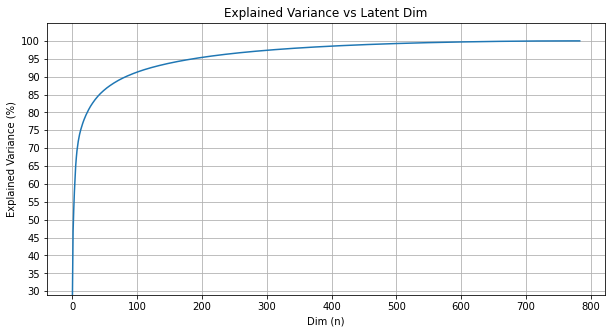

In [33]:
explained_vars = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize = (10, 5))
plt.plot(explained_vars)
plt.title('Explained Variance vs Latent Dim')
plt.xlabel('Dim (n)')
plt.ylabel('Explained Variance (%)')
plt.yticks(ticks=np.arange(0, 101, 5))
plt.ylim(explained_vars[0], 105)
plt.grid(True)

Based on the above figure, We will target a dimension of 200 for the latent space

In [34]:
from tensorflow.keras.models import Model

In [35]:
hu_size = 400
latent_dim = 200
input_shape = X_train.shape[1]

m2_input = Input(shape = (input_shape,), name='encoder_input')
m2_layer_hu = Dense(hu_size, activation = 'relu', name='encoder_hidden_unit')(m2_input)
m2_encoded = Dense(latent_dim, activation = 'sigmoid', name = 'encoder_output')(m2_layer_hu)

encoder_layers = [m2_input, m2_layer_hu, m2_encoded]

encoder = Model(m2_input, m2_encoded, name = 'Encoder_Model')

m2_dec_input = Input(shape = (latent_dim,), name = 'decoder_input')
m2_dec_layer_hu = Dense(hu_size, activation = 'relu', name = 'decoder_hidden_unit')(m2_dec_input)
m2_dec_output = Dense(input_shape, activation='sigmoid', name='decoder_output')(m2_dec_layer_hu)

decoder = Model(m2_dec_input, m2_dec_output, name = 'Decoder_Model')

decoder_output = decoder(encoder(m2_input))

ae_model = Model(m2_input, decoder_output, name = 'Full_Autoencoder_Model')

In [36]:
ae_model.summary(expand_nested=True)

Model: "Full_Autoencoder_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 Encoder_Model (Functional)  (None, 200)               394200    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| encoder_input (InputLayer)  [(None, 784)]           0         |
|                                                               |
| encoder_hidden_unit (Dense)  (None, 400)            314000    |
|                                                               |
| encoder_output (Dense)    (None, 200)               80200     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 Decoder_Model (Functional)  (None, 784)               394784    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| decoder_input (InputLayer)  [(None, 200)] 

In [37]:
rmsprop = kr.optimizers.RMSprop(learning_rate = 0.001)
ae_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
ae_model.fit(X_train, X_train, epochs=5, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3119 - accuracy: 0.0156 - val_loss: 0.2912 - val_accuracy: 0.0194
Epoch 2/5
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2842 - accuracy: 0.0258 - val_loss: 0.2807 - val_accuracy: 0.0291
Epoch 3/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2776 - accuracy: 0.0329 - val_loss: 0.2757 - val_accuracy: 0.0450
Epoch 4/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2743 - accuracy: 0.0374 - val_loss: 0.2733 - val_accuracy: 0.0470
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2722 - accuracy: 0.0411 - val_loss: 0.2694 - val_accuracy: 0.0455


In [39]:
for layer in encoder.layers:
    layer.trainable = False

In [40]:
classifier_input = Input(shape=(latent_dim,), name='classifier_input')
classifier_hu = Dense(250, activation='relu', name='classifier_hidden_unit')(classifier_input)
classifier_output = Dense(y_train_ohe.shape[1], activation='softmax', name = 'classifier_output')(classifier_hu)

ae_classifier = Model(classifier_input, classifier_output, name='Classifier')

ae_clf_output = ae_classifier(encoder(m2_input))

full_ae_clf_model = Model(m2_input, ae_clf_output, name='full_ae_classifier_model')

In [41]:
full_ae_clf_model.summary(expand_nested=True)

Model: "full_ae_classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 Encoder_Model (Functional)  (None, 200)               394200    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| encoder_input (InputLayer)  [(None, 784)]           0         |
|                                                               |
| encoder_hidden_unit (Dense)  (None, 400)            314000    |
|                                                               |
| encoder_output (Dense)    (None, 200)               80200     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 Classifier (Functional)     (None, 10)                52760     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| classifier_input (InputLaye  [(None, 200

In [42]:
full_ae_clf_model.compile(optimizer = kr.optimizers.RMSprop(learning_rate=0.001)
                         ,loss='categorical_crossentropy'
                         , metrics=['accuracy'])

In [43]:
full_ae_clf_model.fit(X_train, y_train_ohe, batch_size=32, epochs=5, validation_data=(X_test, y_test_ohe))

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4605 - accuracy: 0.8363 - val_loss: 0.3782 - val_accuracy: 0.8634
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3579 - accuracy: 0.8683 - val_loss: 0.3460 - val_accuracy: 0.8738
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3300 - accuracy: 0.8784 - val_loss: 0.3352 - val_accuracy: 0.8768
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3136 - accuracy: 0.8844 - val_loss: 0.3097 - val_accuracy: 0.8877
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3022 - accuracy: 0.8892 - val_loss: 0.3192 - val_accuracy: 0.8842


## Section 3: Convolutional Neural Network

In [45]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [46]:
X_train_cnn = X_train.reshape(-1,28,28,1)
X_test_cnn = X_test.reshape(-1,28,28,1)

In [47]:
cnn_input = Input(shape=X_train_cnn.shape[1:], name='CNN_input')
conv1 = Conv2D(32,(3 ,3) ,activation='relu', input_shape=X_train_cnn.shape[1:], name='conv_1')(cnn_input)
conv2 = Conv2D(32,(3 ,3) ,activation='relu', name='conv_2')(conv1)
mxpool1 = MaxPooling2D(pool_size=(3,3), name='pooling_layer_1')(conv2)
conv3 = Conv2D(64,(3 ,3) ,activation='relu', name='conv_3')(mxpool1)
conv4 = Conv2D(64,(3 ,3) ,activation='relu', name='conv_4')(conv3)
mxpool2 = MaxPooling2D(pool_size=(3,3), name='pooling_layer_2')(conv4)
drop1 = Dropout(0.25, name='droupout_regularization_0.25')(mxpool2)
flt = Flatten()(drop1)
cnn_dense = Dense(150, activation='relu', name='hidden_dense_unit')(flt)
cnn_output = Dense(y_train_ohe.shape[1], activation='softmax', name='cnn_output')(cnn_dense)

cnn_model = Model(cnn_input, cnn_output, name='CNN_Model')

In [48]:
cnn_model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 32)        9248      
                                                                 
 pooling_layer_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv_3 (Conv2D)             (None, 6, 6, 64)          18496     
                                                                 
 conv_4 (Conv2D)             (None, 4, 4, 64)          36928     
                                                         

In [49]:
cnn_model.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
cnn_model.fit(X_train_cnn, y_train_ohe, epochs=5, batch_size=32, validation_data=(X_test_cnn, y_test_ohe))

Epoch 1/5
1875/1875 [==============================] - 106s 56ms/step - loss: 0.6189 - accuracy: 0.7731 - val_loss: 0.3720 - val_accuracy: 0.8555
Epoch 2/5
1875/1875 [==============================] - 106s 57ms/step - loss: 0.3906 - accuracy: 0.8583 - val_loss: 0.2941 - val_accuracy: 0.8928
Epoch 3/5
1875/1875 [==============================] - 104s 55ms/step - loss: 0.3381 - accuracy: 0.8790 - val_loss: 0.2995 - val_accuracy: 0.8958
Epoch 4/5
1875/1875 [==============================] - 101s 54ms/step - loss: 0.3185 - accuracy: 0.8864 - val_loss: 0.2666 - val_accuracy: 0.9000
Epoch 5/5
1875/1875 [==============================] - 103s 55ms/step - loss: 0.3081 - accuracy: 0.8929 - val_loss: 0.2665 - val_accuracy: 0.9026
